Deep Transformer Models for Time Series Forecasting: The Influenza Prevalence Case

http://arxiv.org/abs/2001.08317v1

https://blog.brainpad.co.jp/entry/2021/02/17/140000



トランスフォーマーをベースとした時系列モデルの開発

### モデル
#### 問題設定
教師あり機械学習タスクとして ILI予測を定式化します。
N個の週次のデータ点$x_{t−N+1},\cdots,x_{t−1},x_t$を考えると、$M$ステップ先の予測では、教師ありMLモデルの入力$X$は$x_{t−N+1},\cdots,x_{t−M}$、出力$Y$は$x_{t−M+1},x_{t−M+2},\cdots,x_t$です。
各データ点$x_t$は、複数の特徴を含むスカラーまたはベクトルとして考えることができます。

#### Transformerモデル
今回のモデルはオリジナルのTransformerモデルに従い、Encoder・Decoderで構成されます。

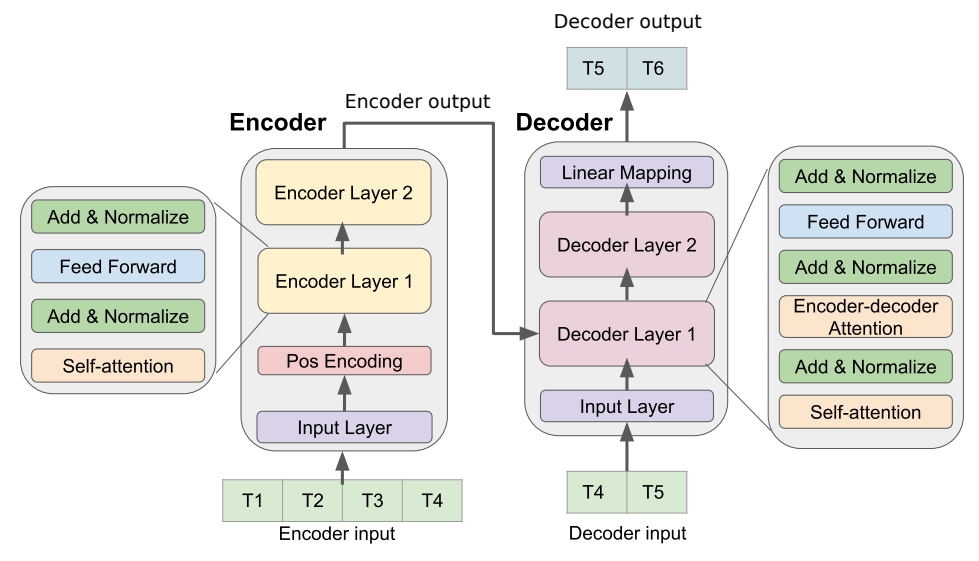

##### Encoder
Encoderは、input layer、positional encoding layer(PE layer)、および4つの同一のencoder layerの積み重ねで構成されます。
input layerでは、全結合ネットワークにより入力時系列データを次元$d_{model}$のベクトルにマッピングします。
サイン関数とコサイン関数を使用したPEは、入力ベクトルとPEベクトルを要素ごとに加算することによって、時系列データに位置情報を付与するために使用されます。
PE layerから出力されたベクトルは、4つのencoder layerに入力されます。
各encoder layerは、self-attention sub-layerと全結合のfeed-forward sub-layerの2つのsub-layerで構成されます。
各sub-layerの後には、normalization layerが続きます。
encoderは、$d_{model}$次元のベクトルを生成して、decoderに供給します。

##### Decoder
Decoderも、input layer、4つの同一のDecoder layer、およびoutput layerで構成されます。
Decoderの入力は、Encoderの入力の最後のデータ点から始まります。
input layerは、Decoderの入力を $d_{model}$次元のベクトルにマッピングします。
Decoderは各Encoder layerの2つのsub-layerに加えて3番目のsub-layerを挿入して、Encoderの出力にself-attentionを適用します。
最後に、decoder layerの出力をターゲットの時系列にマッピングするoutput layerがあります。
時系列データ点の予測が以前のデータ点のみに依存させるため、look-ahead maskingと、Decoderの入力とターゲット出力の間のone-position offsetを採用しています。

##### Time Delay Embedding
スカラー時系列データ$x_t$の場合、その時間遅延埋め込み(TDE)は、各$x_t$を$d$次元の時間遅延空間に埋め込むことによって形成されます。
$$
TDE_{d,\tau}(x_t)=(x_t,x_{t−\tau}, \cdots, x_{t−(d−1)\tau})
$$

通常の時系列予測のようにスライド窓でデータを切り取っていくことがTDEとなるので、今回は入力前に処理をしてEmbedding層は入れないこととにします。

#### データ
インフルエンザの患者数データを使用
Cdc fluview dashboard. https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html.
訓練用とテスト用に分けて使用。2020年以降は新型コロナの影響で傾向が大きく変わっているので2020年までのデータを使用。
前処理としてMinMaxスケーリングを行う。


#### トレーニング
10個(週)のデータ点から4点(週)先のILI比率を予測します。
encoder入力$(x_1, x_2, \cdots, x_{10})$とdecoder入力$(x_{10},\cdots,x_{13})$が与えられたときに、decoderは$(x_{11},\cdots,x_{14})$を出力するようにします。
look-ahead maskingを適用して、モデルが予測対象より前のデータ点にのみattentionを適用するようにします。
つまり、$(x_{11}, x_{12})$を予測するとき、マスクはDecoderが$x_{12}$と$x_{13}$の情報を漏らさないように、attention weightを$(x_{10}, x_{11})$のみに置きます。
トレーニングに使用するのはサイズ64のミニバッチとします。

#### Optimizer
最適化関数としてはAdamを使用し、$\beta_1=0.9,\beta_2=0.98,\epsilon=10^{-9}$とします。
学習率は、以下のスケジュールに従うものとします。
$$
lrate=d_{model}^{0.5}*\min(step\_num^{0.5},step\_num*warmup\_step^{-1.5})
$$
ここで、$warmup\_steps=5000$とします。

#### Regularization
encoderとdecoderの3つのsub-layer(self-attention,feed-forward,normalization)にdropoutを適用します。dropout rateは0.2とします。

#### Evaluation
ピアソンの相関係数とRMSEを計算します。

#### 実装
#### keras

transformerの分類モデルから変わった部分は、
・Embedding処理を省略(Time Delay Embeddingは前処理として事前に行う)
・マスク処理をDecoderのみで行う
です。ほぼそのまま使用しているのでコードの内容は説明しません。

In [25]:
import pandas as pd
import numpy as np

data = pd.read_csv('ts_sampledata.txt', sep='\t')
train_data = np.array(data)[:,2]


window_width = 15
dmodel = 64
pred_points = 4

emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])

encinput = np.array([emb_data[i:i+window_width] for i in range(len(emb_data)-window_width-pred_points)])
print(encinput.shape)

decinput = np.array([emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(decinput.shape)

y = np.array([emb_data[i+window_width:i+window_width+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(y.shape)

(44917, 15, 64)
(44917, 4, 64)
(44917, 4, 64)


In [26]:
encinput.shape

(44917, 15, 64)

In [27]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, Activation, Dropout, LayerNormalization, Reshape, Embedding, MultiHeadAttention
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import math

import matplotlib.pyplot as plt

In [28]:
class AddPositionalEncoding(Layer):
    '''
    入力テンソルに対し、位置の情報を付与して返すレイヤー
    see: https://arxiv.org/pdf/1706.03762.pdf

    PE_{pos, 2i}   = sin(pos / 10000^{2i / d_model})
    PE_{pos, 2i+1} = cos(pos / 10000^{2i / d_model})
    '''
    def call(self, inputs):
        fl_type = inputs.dtype
        batch_size, max_length, depth = tf.unstack(tf.shape(inputs))

        depth_counter = tf.range(depth) // 2 * 2  # 0, 0, 2, 2, 4, ...
        depth_matrix = tf.tile(tf.expand_dims(depth_counter, 0), [max_length, 1])  # [max_length, depth]
        depth_matrix = tf.pow(10000.0, tf.cast(depth_matrix / depth, fl_type))  # [max_length, depth]

        # cos(x) == sin(x + π/2)
        phase = tf.cast(tf.range(depth) % 2, fl_type) * math.pi / 2  # 0, π/2, 0, π/2, ...
        phase_matrix = tf.tile(tf.expand_dims(phase, 0), [max_length, 1])  # [max_length, depth]

        pos_counter = tf.range(max_length)
        pos_matrix = tf.cast(tf.tile(tf.expand_dims(pos_counter, 1), [1, depth]), fl_type)  # [max_length, depth]

        positional_encoding = tf.sin(pos_matrix / depth_matrix + phase_matrix)
        # [batch_size, max_length, depth]
        positional_encoding = tf.tile(tf.expand_dims(positional_encoding, 0), [batch_size, 1, 1])

        return inputs + positional_encoding

In [29]:
class MultiHeadAttention(Layer):
    '''
    Multi-Head Attentionレイヤ
    
    hidden_dim : Embeddingされた単語ベクトルの長さ
    heads_num : マルチヘッドAttentionのヘッド数
       ※hidden_numはheads_numで割り切れえる値とすること
    drop_rate : 出力のDropout率

    model = MultiheadAttention(
        hidden_dim = 512,
        head_num = 8,
        drop_rate = 0.5
    )
    '''
    def __init__(self, hidden_dim, heads_num, drop_rate=0.5):
        super(MultiHeadAttention, self).__init__()
        # 入力の線形変換
        # 重み行列は[hidden_dim, hidden_dim]
        self.query = Conv1D(hidden_dim, kernel_size=1)
        self.key   = Conv1D(hidden_dim, kernel_size=1)
        self.value = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力の線形変換
        self.projection = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力のDropout
        self.drop = Dropout(drop_rate)
        
        self.nf = hidden_dim
        self.nh = heads_num
    
    def atten(self, query, key, value, attention_mask, training):
        """
        Attention
        
        query, key, value : 入力
        attention_mask : attention weight に適用される mask
        """
        # 各値を取得
        shape = query.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[2] # トークン列数
        hidden_dim = shape[1]*shape[3] # 入力チャンネル数
        
        # ここで q と k の内積を取ることで、query と key の単語間の関連度のようなものを計算します。
        # tf.matmulで最後の2成分について積を計算(それ以外は形がそろっている必要あり)
        # transpose_bで転置
        # [token_num, hidden_dim/head_num] @ [hidden_dim/head_num, token_num] = [token_num, token_num]
        scores = tf.matmul(query, key, transpose_b=True)
        
        # scoreをhidden_dimの平方根割る
        scores = tf.multiply(scores, tf.math.rsqrt(tf.cast(hidden_dim, tf.float32)))
        
        # Attention Maskがあればscoreに加算
        # attention_mask: [batch_size, token_num, token_num] 
        # マスク(参照しない部分)の場所に1、使用する部分は0とする
        # 1の部分を -無限大にする(softmax(-無限大)=0となる)
        # 1. PADを無視
        # 2. DecoderのSelf-Attentionで未来の情報を参照できないようにする
        if attention_mask is not None:
            scores = scores + attention_mask * -1e9
        # softmax を取ることで正規化します
        # input(query) の各単語に対して memory(key) の各単語のどこから情報を引いてくるかの重み
        atten_weight = tf.nn.softmax(scores)
        
        # 重みに従って value から情報を引いてきます
        # [token_num, token_num] @ [token_num, hidden_dim/head_num] = [token_num, hidden_dim/head_num]
        # input(query) の単語ごとに memory(value)の各単語 に attention_weight を掛け合わせて足し合わせた ベクトル(分散表現の重み付き和)を計算
        context = tf.matmul(atten_weight, value)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        context = tf.transpose(context, [0, 2, 1, 3])
        context = tf.reshape(context, (batch_size, token_num, hidden_dim))
        
        # 線形変換
        context = self.projection(context, training=training)
        
        return self.drop(context, training=training), atten_weight

    def _split(self, x):
        """
        query, key, valueを分割する
        
        入力 shape: [batch_size, length, hidden_dim] の時
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        """
        # 各値を取得
        hidden_dim = self.nf
        heads_num = self.nh
        shape = x.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[1] # トークン列数
        
        # [batch_size, token_num, hidden_dim] -> [batch_size, token_num, head_num, hidden_dim/head_num]
        # splitだが実際は次元を拡張する処理
        x = tf.reshape(x, (batch_size, token_num, heads_num, int(hidden_dim/heads_num)))
        
        # [batch_size, token_num, head_num, hidden_dim/head_num] -> [batch_size, head_num, token_num, hidden_dim/head_num]
        x = tf.transpose(x, [0, 2, 1, 3])
        return x
    
    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=False):
        """
        モデルの実行
        
        input : 入力(query) [batch_size, token_num, hidden_dim]
        memory : 入力(key, value) [batch_size, token_num, hidden_dim]
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        """
        # memoryが入力されない場合、memory=input(Self Attention)とする
        if memory is None:
            memory = x

        # input -> query
        # memory -> key, value
        # [batch_size, token_num, hidden_dim] @ [hidden_dim, hidden_dim] -> [batch_size, token_num, hidden_dim] 
        query = self.query(x)
        key = self.key(memory)
        value = self.value(memory)
        
        # ヘッド数に分割する
        # 実際はreshapeで次数を1つ増やす
        # [batch_size, token_num, hidden_dim] -> [batch_size, head_num, token_num, hidden_dim/head_num]
        query = self._split(query)
        key = self._split(key)
        value = self._split(value)
        
        # attention
        # 入力と同じ形の出力
        # context: [batch_size, token_num, hidden_dim]
        # score_weightsはEncoderではNoneとする
        context, attn_weights = self.atten(query, key, value, attention_mask, training)
        if not return_attention_scores:
            return context
        else:
            return context, attn_weights

In [30]:
class FeedForwardNetwork(Layer):
    '''
    Position-wise Feedforward Neural Network
    transformer blockで使用される全結合層
    '''
    def __init__(self, hidden_dim, drop_rate):
        super().__init__()
        # 2層構造
        # 1層目：チャンネル数を増加させる
        self.filter_dense_layer = Dense(hidden_dim * 4, use_bias=True, activation='relu')
        
        # 2層目：元のチャンネル数に戻す
        self.output_dense_layer = Dense(hidden_dim, use_bias=True)
        self.drop = Dropout(drop_rate)

    def call(self, x, training):
        '''
        入力と出力で形が変わらない
        [batch_size, token_num, hidden_dim]
        '''
        
        # [batch_size, token_num, hidden_dim] -> [batch_size, token_num, 4*hidden_dim]
        x = self.filter_dense_layer(x)
        x = self.drop(x, training=training)
        
        # [batch_size, token_num, 4*hidden_dim] -> [batch_size, token_num, hidden_dim]
        return self.output_dense_layer(x)

In [31]:
class ResidualNormalizationWrapper(Layer):
    '''
    残差接続
    output: input + SubLayer(input)
    '''
    def __init__(self, layer, drop_rate):
        super().__init__()
        self.layer = layer # SubLayer : ここではAttentionかFFN
        self.layer_normalization = LayerNormalization()
        self.drop = Dropout(drop_rate)

    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=None):
        """
        AttentionもFFNも入力と出力で形が変わらない
        [batch_size, token_num, hidden_dim]
        """
        
        params = {}
        if memory is not None:
            params['memory'] = memory
        if attention_mask is not None:
            params['attention_mask'] = attention_mask
        if return_attention_scores:
            params['return_attention_scores'] = return_attention_scores
        
        out = self.layer_normalization(x)
        if return_attention_scores:
            out, attn_weights = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out, attn_weights
        else:
            out = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out

In [32]:
class EncoderLayer(Layer):
    """
    encoder layer : before ->[self attention -> FF]-> next
    それぞれ残差接続とLayerNormalizationの処理が含まれる
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_numはheads_numで割り切れえる値とすること
        """
        super().__init__()
        self.atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim, drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory=None, attention_mask=None, return_attention_scores=False):
        """
        入力と出力で形式が変わらない
        [batch_size, token_num, hidden_dim]
        """
        
        if return_attention_scores:
            x, attn_weights = self.atten(input,training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x, attn_weights
        else:
            x = self.atten(input, training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x

In [33]:
class Encoder(Layer):
    '''
    TransformerのEncoder
    '''
    def __init__(
            self,
            hopping_num, # Multi-head Attentionの繰り返し数
            heads_num, # Multi-head Attentionのヘッド数
            hidden_dim, # Embeddingの次数
            drop_rate, # ドロップアウトの確率
    ):
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [EncoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(
            self,
            input,
            training,
            memory=None,
            attention_mask=None,
            return_attention_scores=False
    ):
        '''
        input: 入力 [batch_size, length]
        memory: 入力 [batch_size, length]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)
        
        
        if return_attention_scores:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query, atten_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query), atten_weights
        else:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query)

In [34]:
class DecoderLayer(Layer):
    """
    decoder layer : before ->[mask attention -> enc attention -> FF]-> next
    mask attentionは未来の情報を参照しないためのマスクを適用
    enc attentionはencoderの出力をkey, valueとする。
    それぞれ残差接続とLayerNormalizationの処理が含まれる
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_numはheads_numで割り切れえる値とすること
        """
        super().__init__()
        self.mask_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.enc_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim, drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory=None, attention_mask=None, return_attention_scores=False):
        """
        入力と出力で形式が変わらない
        [batch_size, token_num, hidden_dim]
        """
        
        if return_attention_scores:
            x, dec_attn_weights = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=return_attention_scores)
            x, encdec_attn_weights = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=return_attention_scores)
            x = self.ffn(x)
            return x, dec_attn_weights, encdec_attn_weights
        else:
            x = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=False)
            x = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=False)
            x = self.ffn(x)
            return x

In [35]:
class Decoder(Layer):
    '''
    TransformerのDecoder
    '''
    def __init__(
            self,
            hopping_num, # Multi-head Attentionの繰り返し数
            heads_num, # Multi-head Attentionのヘッド数
            hidden_dim, # Embeddingの次数
            drop_rate, # ドロップアウトの確率
    ):
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [DecoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(
            self,
            input,
            training,
            memory=None,
            attention_mask=None,
            return_attention_scores=False
    ):
        '''
        input: 入力 [batch_size, length]
        memory: 入力 [batch_size, length]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        出力 [batch_size, length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)
        
        # MultiHead Attentionを繰り返し適用
        #for i in range(self.hopping_num):
        #    query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

        # [batch_size, token_num, hidden_dim]
        #return self.output_normalization(query)
    
        if return_attention_scores:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query, dec_attn_weights, encdec_attn_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query), dec_attn_weights, encdec_attn_weights
        else:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query)

In [36]:
class TransformerTimeSeriesForecast(Model):
    """
    Transformerベースの時系列予測モデル
    
    """
    def __init__(
            self,
            hopping_num, # Multi-head Attentionの繰り返し数
            heads_num, # Multi-head Attentionのヘッド数
            hidden_dim, # Embeddingの次数
            drop_rate, # ドロップアウトの確率
    ):
        super().__init__()
        self.encoder = Encoder(hopping_num, heads_num, hidden_dim, drop_rate)
        self.decoder = Decoder(hopping_num, heads_num, hidden_dim, drop_rate)
        
        self.fc = Dense(8)
        self.dropout = Dropout(drop_rate)
        self.final_layer = Dense(1)

    def call(self, inputs, training, return_attention_scores=False):
        enc_input, dec_input = inputs
        
        self_attention_mask=self._create_look_ahead_mask(dec_input)
        
        # [batch_size, token_num] -> [batch_size, token_num, hidden_dim]
        if return_attention_scores:
            enc_output, enc_atten_weights = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        else:
            enc_output = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        
        #dec_output = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask)
        if return_attention_scores:
            dec_output, dec_attn_weights, encdec_attn_weights = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
        else:
            dec_output = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
       
        
        # [batch_size, hidden_dim] -> [batch_size, NUMLABELS]
        fc_output = self.fc(dec_output)
        fc_output = self.dropout(fc_output)
        final_output = self.final_layer(fc_output)

        if return_attention_scores:
            return final_output, enc_atten_weights, dec_attn_weights, encdec_attn_weights
        else:
            return final_output
    
    def _create_look_ahead_mask(self, x):
        batch_size, length, _ = x.shape
        autoregression_array = tf.logical_not(tf.linalg.band_part(tf.ones([length, length], dtype=tf.bool), -1, 0))  # 下三角が False
        autoregression_array = tf.reshape(autoregression_array, [1, 1, length, length])
        return tf.cast(autoregression_array, dtype=tf.float32)

(654, 10, 8)
(654, 4, 8)
(654, 4, 8)


(0.0, 600.0)

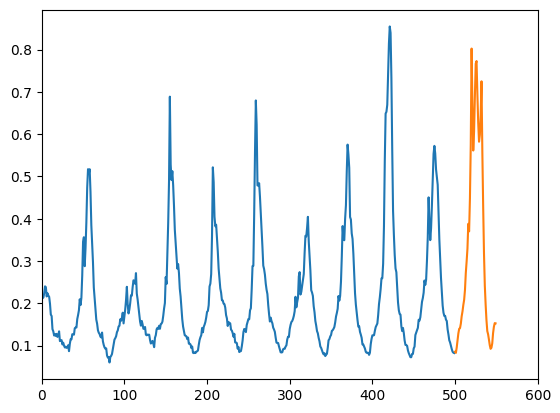

In [37]:
class minmaxscaling:
    def __init__(self,max_value, min_value, upl=0, downl=0):
        self.max = max_value + max_value*upl
        self.min = min_value - min_value*downl
    
    def translate(self, x):
        return (x - self.min) / (self.max - self.min)

window_width = 10
dmodel = 8
pred_points = 4

data = pd.read_csv('ilidata.csv')
train_data = np.array(data[['WEIGHTED_ILI']])

scaler = minmaxscaling(8, 0, 0.1)
train_data = scaler.translate(train_data).ravel()

emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])

encinput = np.array([emb_data[i:i+window_width] for i in range(len(emb_data)-window_width-pred_points)])
print(encinput.shape)

decinput = np.array([emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(decinput.shape)

y = np.array([emb_data[i+window_width:i+window_width+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(y.shape)

enc_train, enc_test = encinput[:500,:,:], encinput[500:550,:,:]
dec_train, dec_test = decinput[:500,:,:], decinput[500:550,:,:]
y_train, y_test = y[:500,:,0], y[500:550,:,0]

enc_train = tf.constant(enc_train)
enc_test = tf.constant(enc_test)
dec_train = tf.constant(dec_train)
dec_test = tf.constant(dec_test)
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

plt.plot(np.arange(500), y[:500,-1,0]);
plt.plot(np.arange(500,550), y[500:550,-1,0])
plt.xlim(0,600)

In [38]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

model = TransformerTimeSeriesForecast(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=1, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [39]:
import time
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
63/63 - 17s - loss: 0.6961 - mse: 0.6961 - lr: 0.0000e+00 - 17s/epoch - 272ms/step
Epoch 2/200
63/63 - 1s - loss: 0.6542 - mse: 0.6542 - lr: 8.0000e-06 - 689ms/epoch - 11ms/step
Epoch 3/200
63/63 - 1s - loss: 0.6600 - mse: 0.6600 - lr: 1.6000e-05 - 710ms/epoch - 11ms/step
Epoch 4/200
63/63 - 1s - loss: 0.6265 - mse: 0.6265 - lr: 2.4000e-05 - 760ms/epoch - 12ms/step
Epoch 5/200
63/63 - 1s - loss: 0.5711 - mse: 0.5711 - lr: 3.2000e-05 - 690ms/epoch - 11ms/step
Epoch 6/200
63/63 - 1s - loss: 0.4931 - mse: 0.4931 - lr: 4.0000e-05 - 668ms/epoch - 11ms/step
Epoch 7/200
63/63 - 1s - loss: 0.4395 - mse: 0.4395 - lr: 4.8000e-05 - 668ms/epoch - 11ms/step
Epoch 8/200
63/63 - 1s - loss: 0.4276 - mse: 0.4276 - lr: 5.6000e-05 - 708ms/epoch - 11ms/step
Epoch 9/200
63/63 - 1s - loss: 0.3692 - mse: 0.3692 - lr: 6.4000e-05 - 781ms/epoch - 12ms/step
Epoch 10/200
63/63 - 1s - loss: 0.3212 - mse: 0.3212 - lr: 7.2000e-05 - 702ms/epoch - 11ms/step
Epoch 11/200
63/63 - 1s - loss: 0.2672 - mse: 0.2

In [40]:
#model.save('transformer_ts_predict')

16/16 [==============================] - 3s 4ms/step


(0.0, 550.0)

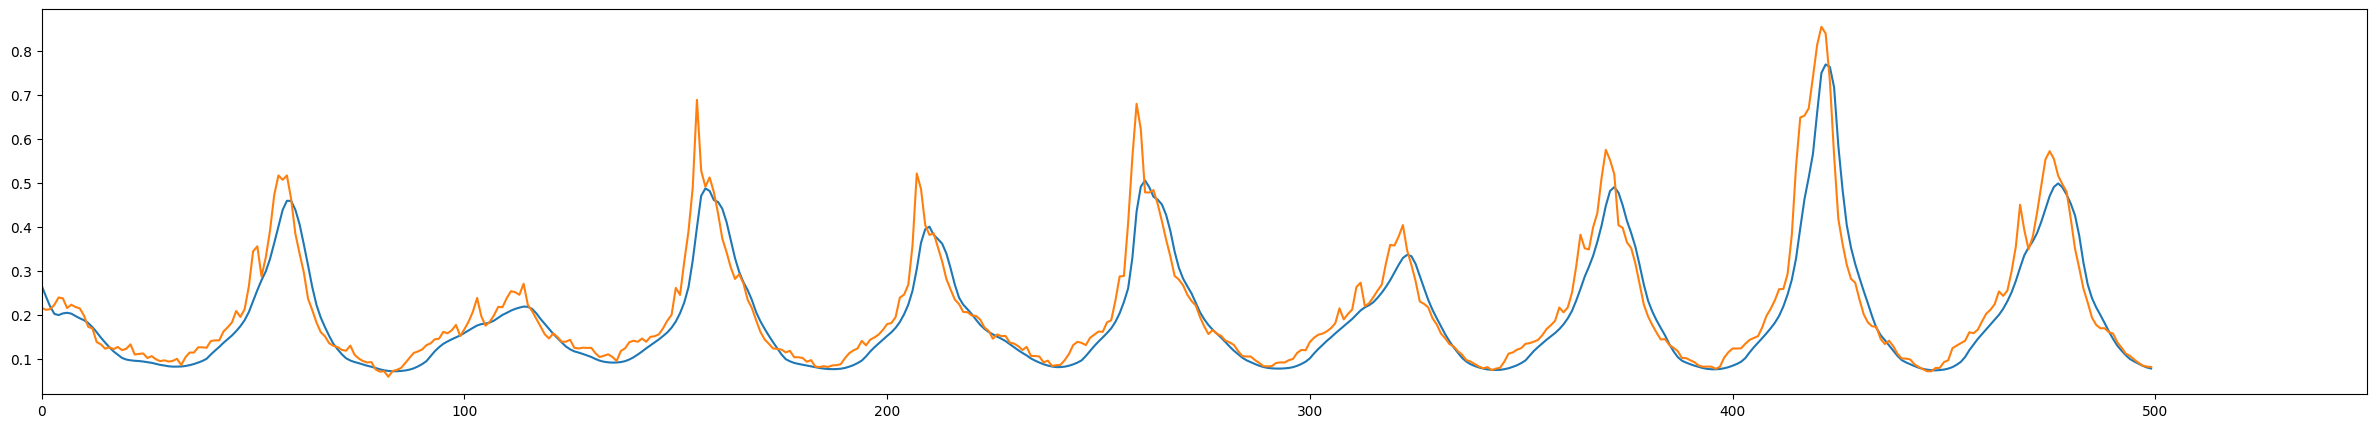

In [41]:
y_pred = model.predict([enc_train,dec_train])

plt.figure(figsize=(30,5))
plt.plot(y_pred[:,1,0])
plt.plot(y_train[:,-1]);
plt.xlim(0,550)

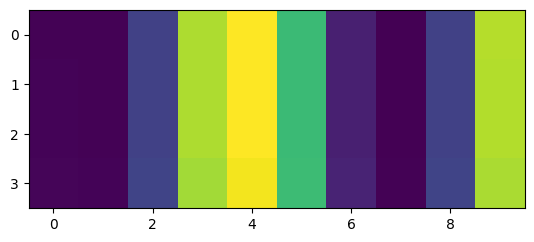

In [42]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [43]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,4,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(4):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

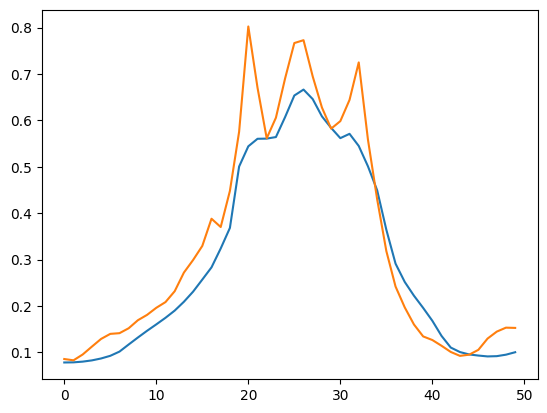

In [44]:
plt.plot(pred_results[:,0,-1,0])
plt.plot(y_test[:,-1]);
#plt.xlim(0,20)
#plt.ylim(0,4)

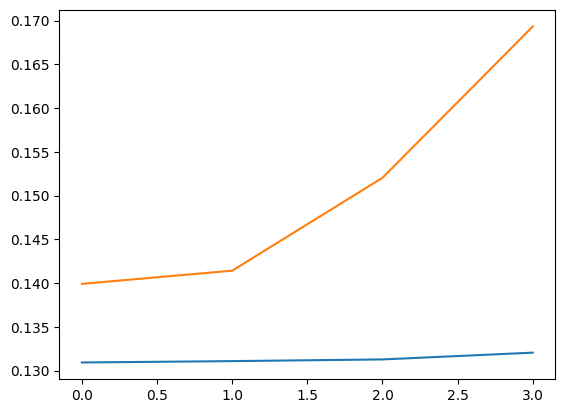

In [45]:
plt.plot(pred_results[8,0])
plt.plot(y_test[8,:])

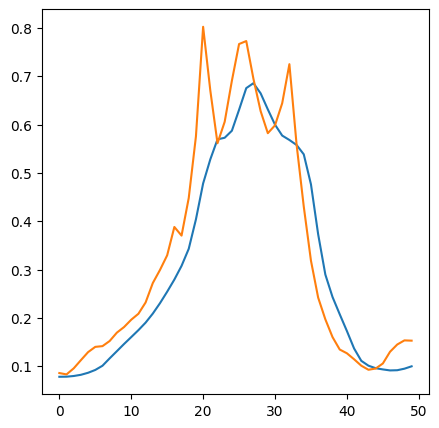

In [46]:
plt.figure(figsize=(5,5))
plt.plot(pred_results[:,0,0,0])
plt.plot(y_test[:,-1]);
#plt.xlim(0,20)
#plt.ylim(0,4)

In [80]:
window_width = 10
dmodel = 16
pred_points = 8

data = pd.read_csv('ilidata.csv')
train_data = np.array(data[['WEIGHTED_ILI']])

scaler = minmaxscaling(8, 0, 0.1)
train_data = scaler.translate(train_data).ravel()

emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])

encinput = np.array([emb_data[i:i+window_width] for i in range(len(emb_data)-window_width-pred_points)])
print(encinput.shape)

decinput = np.array([emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(decinput.shape)

y = np.array([emb_data[i+window_width:i+window_width+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(y.shape)

enc_train, enc_test = encinput[:500,:,:], encinput[500:550,:,:]
dec_train, dec_test = decinput[:500,:,:], decinput[500:550,:,:]
y_train, y_test = y[:500,:,0], y[500:550,:,0]

enc_train = tf.constant(enc_train)
enc_test = tf.constant(enc_test)
dec_train = tf.constant(dec_train)
dec_test = tf.constant(dec_test)
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

(642, 10, 16)
(642, 8, 16)
(642, 8, 16)


In [81]:
model = TransformerTimeSeriesForecast(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=4, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [82]:
import time
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
63/63 - 17s - loss: 1.7471 - mse: 1.7471 - lr: 0.0000e+00 - 17s/epoch - 267ms/step
Epoch 2/200
63/63 - 1s - loss: 1.7237 - mse: 1.7237 - lr: 1.1314e-05 - 1s/epoch - 21ms/step
Epoch 3/200
63/63 - 2s - loss: 1.6034 - mse: 1.6034 - lr: 2.2627e-05 - 2s/epoch - 32ms/step
Epoch 4/200
63/63 - 2s - loss: 1.3131 - mse: 1.3131 - lr: 3.3941e-05 - 2s/epoch - 27ms/step
Epoch 5/200
63/63 - 2s - loss: 1.1746 - mse: 1.1746 - lr: 4.5255e-05 - 2s/epoch - 31ms/step
Epoch 6/200
63/63 - 2s - loss: 1.0168 - mse: 1.0168 - lr: 5.6569e-05 - 2s/epoch - 30ms/step
Epoch 7/200
63/63 - 2s - loss: 0.8489 - mse: 0.8489 - lr: 6.7882e-05 - 2s/epoch - 32ms/step
Epoch 8/200
63/63 - 2s - loss: 0.6754 - mse: 0.6754 - lr: 7.9196e-05 - 2s/epoch - 31ms/step
Epoch 9/200
63/63 - 2s - loss: 0.5352 - mse: 0.5352 - lr: 9.0510e-05 - 2s/epoch - 28ms/step
Epoch 10/200
63/63 - 2s - loss: 0.4364 - mse: 0.4364 - lr: 1.0182e-04 - 2s/epoch - 26ms/step
Epoch 11/200
63/63 - 2s - loss: 0.3463 - mse: 0.3463 - lr: 1.1314e-04 - 2s/e

16/16 [==============================] - 3s 10ms/step


(0.0, 550.0)

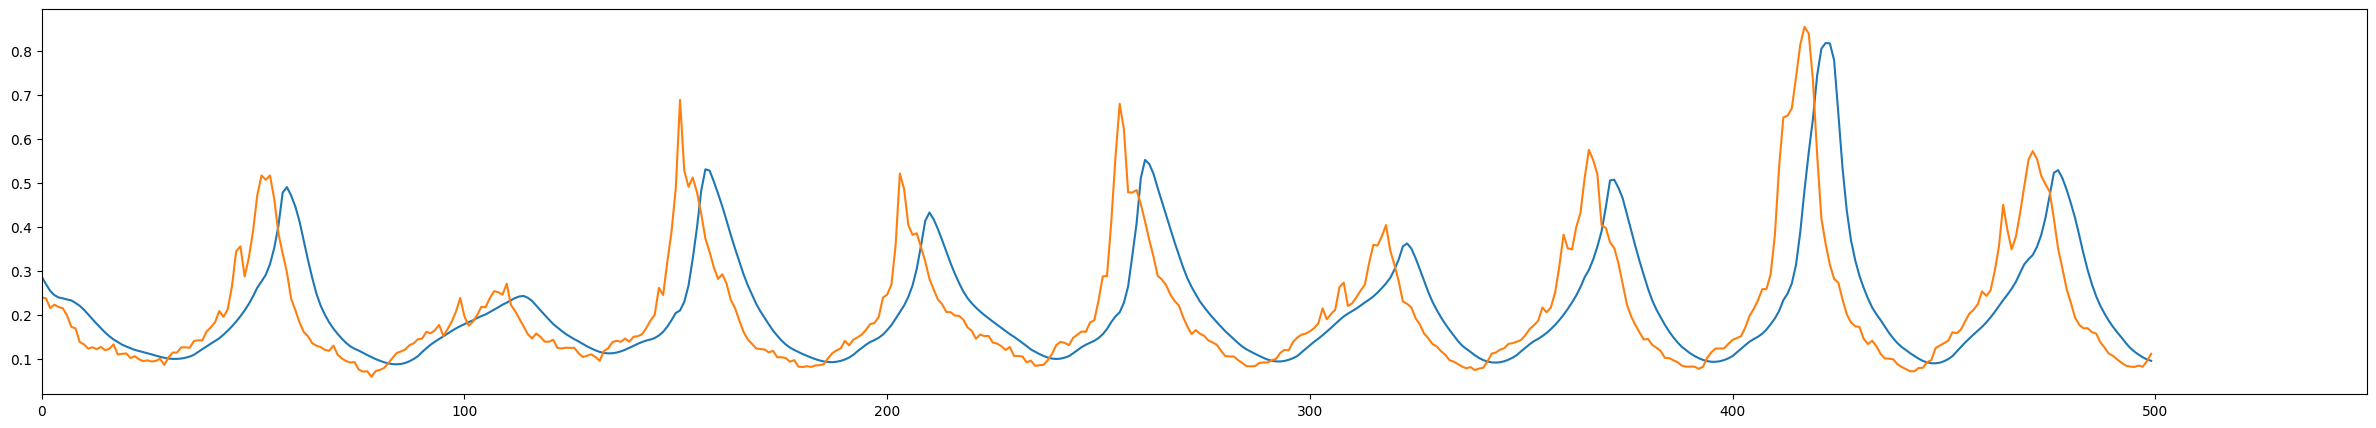

In [83]:
y_pred = model.predict([enc_train,dec_train])

plt.figure(figsize=(30,5))
plt.plot(y_pred[:,1,0])
plt.plot(y_train[:,-1]);
plt.xlim(0,550)

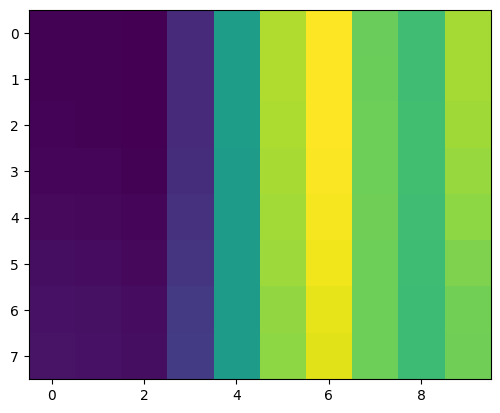

In [84]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [85]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

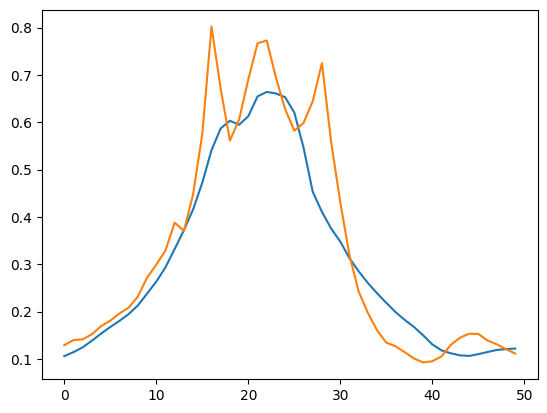

In [86]:
plt.plot(pred_results[:,0,-1,0])
plt.plot(y_test[:,-1]);

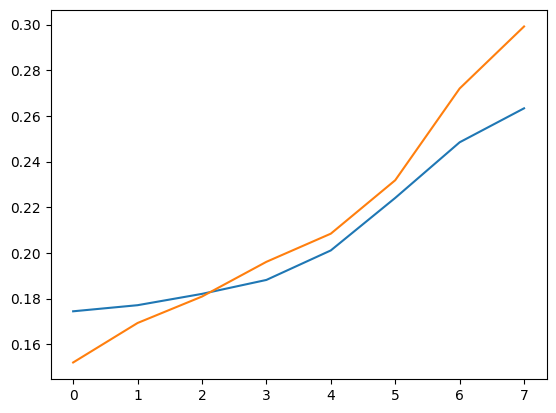

In [87]:
plt.plot(pred_results[10,0])
plt.plot(y_test[10,:])

(50, 1, 8, 1)

In [120]:
window_width = 20
dmodel = 24
pred_points = 16

data = pd.read_csv('ilidata.csv')
train_data = np.array(data[['WEIGHTED_ILI']])

scaler = minmaxscaling(8, 0, 0.1)
train_data = scaler.translate(train_data).ravel()

emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])

encinput = np.array([emb_data[i:i+window_width] for i in range(len(emb_data)-window_width-pred_points)])
print(encinput.shape)

decinput = np.array([emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(decinput.shape)

y = np.array([emb_data[i+window_width:i+window_width+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(y.shape)

enc_train, enc_test = encinput[:500,:,:], encinput[500:550,:,:]
dec_train, dec_test = decinput[:500,:,:], decinput[500:550,:,:]
y_train, y_test = y[:500,:,0], y[500:550,:,0]

enc_train = tf.constant(enc_train)
enc_test = tf.constant(enc_test)
dec_train = tf.constant(dec_train)
dec_test = tf.constant(dec_test)
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

(616, 20, 24)
(616, 16, 24)
(616, 16, 24)


In [121]:
model = TransformerTimeSeriesForecast(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=4, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [122]:
import time
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
63/63 - 18s - loss: 5.2295 - mse: 5.2295 - lr: 0.0000e+00 - 18s/epoch - 290ms/step
Epoch 2/200
63/63 - 2s - loss: 4.2955 - mse: 4.2955 - lr: 1.3856e-05 - 2s/epoch - 32ms/step
Epoch 3/200
63/63 - 2s - loss: 3.5866 - mse: 3.5866 - lr: 2.7713e-05 - 2s/epoch - 32ms/step
Epoch 4/200
63/63 - 2s - loss: 2.9210 - mse: 2.9210 - lr: 4.1569e-05 - 2s/epoch - 32ms/step
Epoch 5/200
63/63 - 2s - loss: 2.1394 - mse: 2.1394 - lr: 5.5426e-05 - 2s/epoch - 32ms/step
Epoch 6/200
63/63 - 2s - loss: 1.5512 - mse: 1.5512 - lr: 6.9282e-05 - 2s/epoch - 32ms/step
Epoch 7/200
63/63 - 2s - loss: 1.1518 - mse: 1.1518 - lr: 8.3138e-05 - 2s/epoch - 32ms/step
Epoch 8/200
63/63 - 2s - loss: 0.8601 - mse: 0.8601 - lr: 9.6995e-05 - 2s/epoch - 33ms/step
Epoch 9/200
63/63 - 2s - loss: 0.6171 - mse: 0.6171 - lr: 1.1085e-04 - 2s/epoch - 32ms/step
Epoch 10/200
63/63 - 2s - loss: 0.4745 - mse: 0.4745 - lr: 1.2471e-04 - 2s/epoch - 32ms/step
Epoch 11/200
63/63 - 2s - loss: 0.3560 - mse: 0.3560 - lr: 1.3856e-04 - 2s/e

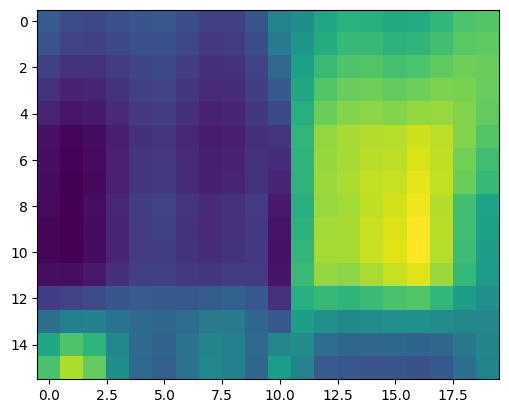

In [123]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [124]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

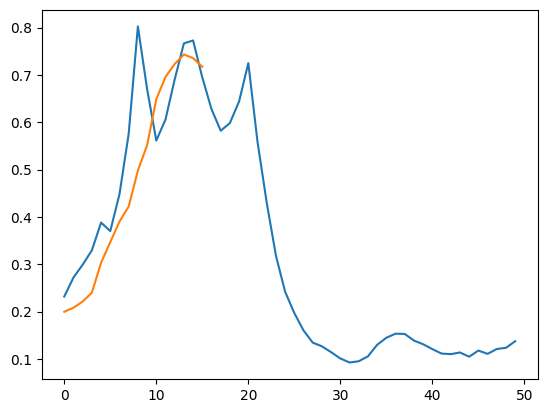

In [125]:
#plt.plot(pred_results[:,0,5,0])
plt.plot(y_test[:,5]);
plt.plot(pred_results[5,0])
#plt.xlim(0,20)
#plt.ylim(0,4)

In [100]:
pred_results.shape

(50, 1, 16, 1)

In [55]:
from pmdarima import auto_arima

In [56]:
import warnings
warnings.filterwarnings("ignore")
  
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(data.loc[:510, ['WEIGHTED_ILI']], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1999.480, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=530.253, Time=0.92 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.81 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1998.694, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=650.250, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=471.783, Time=3.23 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.48 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1870.837, Time=1.29 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=284.591, Time=3.24 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=347.546, Time=1.17 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.47 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=286.556, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  511
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 12)   Log Likelihood                -114.533
Date:                             Fri, 30 Sep 2022   AIC                            243.067
Time:                                     09:12:55   BIC                            272.555
Sample:                                          0   HQIC                           254.639
                                             - 511                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9602      0.008    245.202      0.000       1.945       1.976
ar.L2         -0.9741      0.008   -128.381      0.000      -0.989      -0.959
ma.L1         -0.5186      0.027    -19.548      0.000      -0.571      -0.467
ma.L2         -0.4548      0.028    -16.501      0.000      -0.509      -0.401
ar.S.L12      -0.7026      0.037    -19.134      0.000      -0.775      -0.631
ar.S.L24      -0.3504      0.037     -9.555      0.000      -0.422      -0.278
sigma2         0.0901      0.003     29.577      0.000       0.084       0.096
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               784.49
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(data.loc[:510, ['WEIGHTED_ILI']], 
                order = (3, 0, 3), 
                seasonal_order =(3, 2, 2, 12))
  
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            WEIGHTED_ILI   No. Observations:                  511
Model:             SARIMAX(3, 0, 3)x(3, 2, [1, 2], 12)   Log Likelihood                -114.008
Date:                                 Fri, 30 Sep 2022   AIC                            252.016
Time:                                         09:13:24   BIC                            302.276
Sample:                                              0   HQIC                           271.760
                                                 - 511                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0077      0.072     13.971      0.000       0.866       1.149
ar.L2          0.8481      0.135      6.276      0.000       0.583       1.113
ar.L3         -0.8866      0.070    -12.702      0.000      -1.023      -0.750
ma.L1          0.4643      0.077      5.998      0.000       0.313       0.616
ma.L2         -0.8765      0.062    -14.108      0.000      -0.998      -0.755
ma.L3         -0.3840      0.057     -6.687      0.000      -0.497      -0.271
ar.S.L12      -0.0102      0.065     -0.158      0.874      -0.137       0.117
ar.S.L24       0.0110      0.072      0.153      0.879      -0.130       0.152
ar.S.L36       0.0220      0.062      0.354      0.723      -0.100       0.144
ma.S.L12      -1.9281      0.102    -18.937      0.000      -2.128      -1.729
ma.S.L24       0.9422      0.103      9.117      0.000       0.740       1.145
sigma2         0.0746      0.006     12.978      0.000       0.063       0.086
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               747.96
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
start = 0
end = 560 - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")

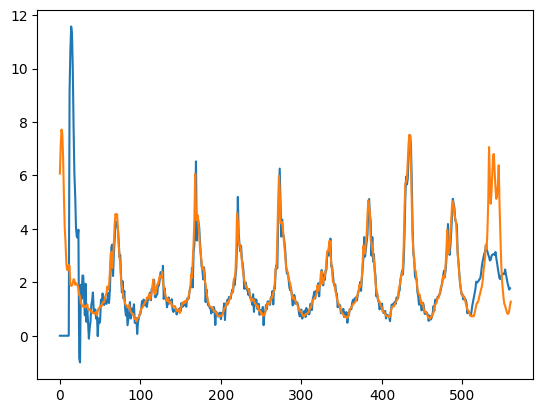

In [59]:
plt.plot(predictions)
plt.plot(data.loc[:560, ['WEIGHTED_ILI']])